# Integration of pygcc with GWB

#### Import pygcc, GWBplugin and other modules

In [1]:
import sys, pygcc, pandas as pd
from pygcc.pygcc_utils import *
print(pygcc.__version__)

KeyboardInterrupt: 

Ensure you have GWB license to run and test this script.

All files used in this tutorial can be downloaded from https://bitbucket.org/Tutolo-RTG/pygcc/src/master/docs/

Download [output_reader](https://bitbucket.org/Tutolo-RTG/pygcc/src/master/docs/output_reader.py) into your working directory

In [9]:
# load GWB plugin
sys.path.append("c:/program files/gwb/src")
sys.path.append(os.path.abspath('.'))

# import GWBplugin class
from GWBplugin import *
# create the plug-in object
myGWBrun = GWBplugin()

from output_reader import read_gwboutput

#### Load filtered vent fluid data
This example is from Syverson, D. D., Awolayo, D., & Tutolo, B. M. (2021). Global constraints on secular changes in mid-ocean ridge subseafloor sulfide deposition and metal fluxes through Earth history. In AGU Fall Meeting 2021. AGU.

Here we will work with EPR 21 N sample to run speciation and warm up the fluid from 25 °C to 355 °C

In [3]:
filename = './MARHYS_DB_2_0_filter.csv'
df = pd.read_csv(filename)
i = 1    
df.loc[1,:]

Sample-ID                        EPR 21°N-SW-1981
Geol_setting         Mid-oceanic spreading center
Rock_type_primary                          Basalt
Depth                                        2500
Temp                                          355
pH                                            3.6
XH2S                                         7.45
Cl                                            496
Na                                            439
Fe                                            750
Mn                                            699
H2                                           0.01
K                                            23.2
Ca                                           16.6
Si                                           17.3
Cu                                            9.7
Press                                     251.945
Name: 1, dtype: object

#### Automate the generation of database for each vent fluid with pygcc and run speciation with gwb React
The gwb output files are stored in the folder 'Ventspec'

In [4]:
T = [20, df.loc[i,:].Temp]
P = np.round(df.loc[i,:].Press)*np.ones(np.size(T))
Temp = df.loc[i,:].Temp;       npH = df.loc[i,:].pH
nCl = df.loc[i,:].Cl;          nNa = df.loc[i,:].Na
nH2S = df.loc[i,:].XH2S;       nFe = df.loc[i,:].Fe
nMn = df.loc[i,:].Mn;          nH2 = df.loc[i,:].H2
nK = df.loc[i,:].K;            nCu = df.loc[i,:].Cu;    
nCa = df.loc[i,:].Ca;          nSi = df.loc[i,:].Si
objdbname = './thermo.%sbars%sC' % (int(P[0]), int(df.loc[i,:].Temp))
write_database(T = [20, Temp], P = P, solid_solution = True, objdb = objdbname, 
               clay_thermo = 'Yes', dataset = 'GWB',  sourcedb =  './database/thermo.com.tdat')

output_folder = 'Vent_spec'
if os.path.exists(os.path.join(os.getcwd(), output_folder)) == False:
    os.makedirs(os.path.join(os.getcwd(), output_folder))

# start the GWB program
if myGWBrun.initialize("react","%s/runs_%s.txt" % (output_folder, i), 
                       "-nocd -d \"./output/GWB/%s.dat\" " % objdbname[1:]):

    cmds = ['H2O  = 1 free kg', 'Fe++  = %s umol/kg' % nFe, "Na+  = %s mmol/kg" % nNa, 
            'pH = %s' % npH, "Cl- = %s mmol/kg" % nCl, "swap H2S(aq) for SO4--", 
            "H2S(aq) = %s mmol/kg" % nH2S, 'Mn++  = %s umol/kg' % nMn, "K+  = %s mmol/kg" % nK, 
            'Ca++  = %s mmol/kg' % nCa, 'SiO2(aq) = %s mmol/kg' % nSi, 'Cu++  = %s umol/kg' % nCu, 
            'temperature initial = 25 C, final = %s C' % Temp, 'swap H2(aq) for O2(aq)', 
            "H2(aq) = %s umol/kg" % nH2,  "balance off"]

    cmds += ['suppress ALL', "plot = character", 'itmax = 9999', "go", 
             'save %s/react%s.rea' % (output_folder, i)]

    for cmd in cmds: 
        myGWBrun.exec_cmd(cmd)

    for fname in os.listdir('./%s' % output_folder):
        if fname.startswith('React_%s.txt' % i):
            os.remove('%s/React_%s.txt' % (output_folder, i))
        if fname.startswith('React_%s.gtp' % i): 
            os.remove('%s/React_%s.gtp' % (output_folder, i))

    os.rename('React_output.txt', '%s/React_%s.txt' % (output_folder, i))
    os.rename('React_plot.gtp', '%s/React_%s.gtp' % (output_folder, i))

print("\nFinished run." )

C:\ProgramData\Anaconda3\lib\site-packages\pygcc\pygcc_utils.py:2266: UserWarning: Some temperature and pressure points are out of aqueous species HKF eqns regions of applicability, hence, density extrapolation has been applied
  warnings.warn('Some temperature and pressure points are out of aqueous species HKF eqns regions of applicability, hence, density extrapolation has been applied')


Success, your new GWB database is ready for download

Finished run.


#### Extract simulation results

In [5]:
rerun = []
path = './' + output_folder + '/'
files = os.listdir(path)
for i, f in enumerate(files):
    if f.endswith('.gtp') and f.startswith('React_'): 
        size = os.path.getsize(path + f)/(1024) #size in KB
        if size > 2:
            data = read_gwboutput(path + f)
        else:
            rerun.append(f)
print(rerun)

[]


In [6]:
# data

Plot pyrite saturation with temperature

Text(0, 0.5, '$Log_{10}$(Q/K)$_{Pyrite}$')

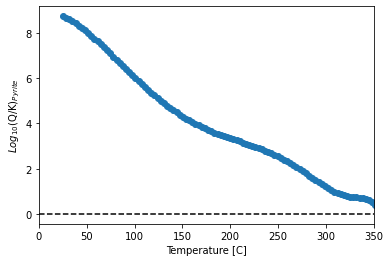

In [7]:
import matplotlib.pyplot as plt
y = data.SI_Pyrite
x = data.Temperature
plt.figure()
plt.scatter(x, y)
plt.plot([0, 350], [0, 0], 'k--')
plt.xlim([0, 350])
plt.xlabel('Temperature [C]')
plt.ylabel('$Log_{10}$(Q/K)$_{Pyrite}$')

pH versus temperature

Text(0, 0.5, 'pH')

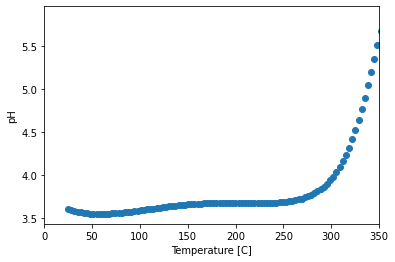

In [8]:
y = data.pH
x = data.Temperature
plt.figure()
sc = plt.scatter(x, y)
plt.xlim([0, 350])
plt.xlabel('Temperature [C]')
plt.ylabel('pH')